In [58]:
import pandas as pd

#### **1. Organizando dados**

In [13]:

df = pd.read_csv("data/aposentadorias.csv")
data = df.to_dict("records")

In [14]:
import os


files = os.listdir("data")
dfs = {}

for f in files:
    dfs[f.split(".")[0]]= pd.read_csv(f"data/{f}").rename(columns={"Instituição": "IFE"})


In [15]:

dados_organizados = []
items = dfs.items()
items = list(items)

nome, df = items[0]
data = df.to_dict("records")
for item in data:
    for ano in range(2015, 2025):
        dados_organizados.append({"IFE": item["IFE"], "ano": ano, nome: item[str(ano)]})

df_total = pd.DataFrame(dados_organizados)

for nome, df in items[1:]:
    dados_organizados = []
    data = df.to_dict("records")
    for item in data:
        for ano in range(2015, 2025):
            
            dados_organizados.append({"IFE": item["IFE"], "ano": ano, nome: item[str(ano)]})

    df_organizado = pd.DataFrame(dados_organizados)
    df_total = pd.merge(df_total, df_organizado, on=["IFE", "ano"])

In [ ]:
df_servidores = pd.read_csv("data/servidores.csv")
nome_sigla = {}
for item in df_servidores.to_dict("records"):
    nome_sigla[item["IFE"]] = item["Sigla"]

In [17]:
df_total["sigla"] = df_total.apply(lambda x: nome_sigla[x["IFE"]], axis=1)

In [20]:
df_total.to_parquet("dados_organizados.parquet")

#### **2. Análise de correlação**

Análise da correlação entre o Conceito Médio dos cursos de Graduação dos anos de 2021, 2022 e 2023, fornecidos pelo Ministério da Educação (MEC), e a rotatividade dos professores das instituições de ensino superior federais no mesmo período.

Como métricas de rotatividade, consideramos:
- **Taxa de desligamento:** a soma entre a quantidade de aposentadorias e desligamentos registrada, dividido pelo total de professores no ano.
- **Taxa de contratação:** a soma entre a contratação de professores titulares e substitutos, dividido pelo total de professores no ano

##### **2.1. Tratamento dos dados**

In [201]:
# Carregando a tabela gerado no tópico 1
df_organizado = pd.read_parquet("dados_organizados.parquet")

# Gerando as métricas descritas
df_taxas = df_organizado.assign(
    taxa_desligamento=(df_organizado.aposentadorias + df_organizado.desligamentos)/df_organizado.servidores, 
    taxa_contratacao=(df_organizado.contratação_pms + df_organizado.contratação_pmss)/df_organizado.servidores,
)

In [202]:
# Carregando o conjunto de dados com os Conceitos Médios de Graduação dos anos de 2021, 2022 e 2023
df_igc = pd.read_excel("data/IGC_2023.xlsx")
df_igc.rename(
    columns={"Ano": "ano", " Sigla da IES": "sigla", " Conceito Médio de Graduação": "conceito"}, 
    inplace=True
)

df_igc_2021 = pd.read_excel("data/IGC_2021.xlsx")
df_2021 = df_igc_2021[[" Ano", " Sigla da IES*", " Conceito Médio de Graduação"]].rename(
    columns={" Ano": "ano", " Sigla da IES*": "sigla", " Conceito Médio de Graduação": "conceito"}
)

igc_2022 = pd.read_excel("data/igc_2022.xlsx")
igc_2022.columns
df_2022 = igc_2022[["Ano", " Sigla da IES", " Conceito Médio de Graduação"]].rename(
    columns={"Ano": "ano", " Sigla da IES": "sigla", " Conceito Médio de Graduação": "conceito"}
)

df_2023 = df_igc[["ano", "sigla", "conceito"]]

# Concatenando e removendo um valor indesejado
df = pd.concat([df_2021, df_2022, df_2023])
df = df[df.ano != '* Nome, sigla, Organização Acadêmica, Categoria Administrativa e código e-MEC da IES são divulgados cosniderando o status de cada dado no momento da isncrição no Enade.']

In [203]:
# Salvando o resultado da concatenação
df.to_parquet("data/igc.parquet")

In [204]:
# Mesclando os dados dos conceitos médios com os dados de rotatividade (df_taxas) para seguir
# com a análise de correlação
df_total = df_taxas.merge(df, how="left", on=["ano", "sigla"])

In [205]:
# Removendo valores nulos
df_filtrado = df_total[
    (df_total.conceito.isnull() == False) &
    (df_total.taxa_desligamento.isnull() == False) &
    (df_total.taxa_contratacao.isnull() == False)
]

In [210]:
df_filtrado.to_parquet("data/conceito_igc_filtrado.parquet")

##### **2.2. Resultados**

In [211]:
df_filtrado = pd.read_parquet("data/conceito_igc_filtrado.parquet")

In [216]:
from scipy.stats import pearsonr, spearmanr

# Verificando as correlações de Pearson e Spearman nos dados
df_reduzido = df_filtrado[df_filtrado.taxa_contratacao < 0.25]
print("-- Pearson --")
sig_des_p = pearsonr(df_reduzido["taxa_desligamento"].to_numpy(), df_reduzido["conceito"].to_numpy())
print(f"Taxa de desligamento - Correlação: {sig_des_p[0]}", f"  p-value: {sig_des_p[1]}")
sig_cont_p =pearsonr(df_reduzido["taxa_contratacao"].to_numpy(), df_reduzido["conceito"].to_numpy())
print(f"Taxa de contratação - Correlação: {sig_cont_p[0]}", f"  p-value: {sig_cont_p[1]}\n")

print("-- Spearman -- ")
sig_des_s = spearmanr(df_reduzido["taxa_desligamento"].to_numpy(), df_reduzido["conceito"].to_numpy())
print(f"Taxa de desligamento - Correlação: {sig_des_s[0]}", f"  p-value: {sig_des_s[1]}")
sig_cont_s = spearmanr(df_reduzido["taxa_contratacao"].to_numpy(), df_reduzido["conceito"].to_numpy())
print(f"Taxa de contratação - Correlação: {sig_cont_s[0]}", f"  p-value: {sig_cont_s[1]}")

-- Pearson --
Taxa de desligamento - Correlação: 0.2359111927756855   p-value: 0.0029352632444299242
Taxa de contratação - Correlação: -0.1984860979666086   p-value: 0.012702776786356342

-- Spearman -- 
Taxa de desligamento - Correlação: 0.2356998937186753   p-value: 0.002961601482464154
Taxa de contratação - Correlação: -0.15113849646426544   p-value: 0.058825446311710515


<Axes: title={'center': 'pearson = -0.19849\nspearman = -0.15114'}, xlabel='conceito', ylabel='taxa_contratacao'>

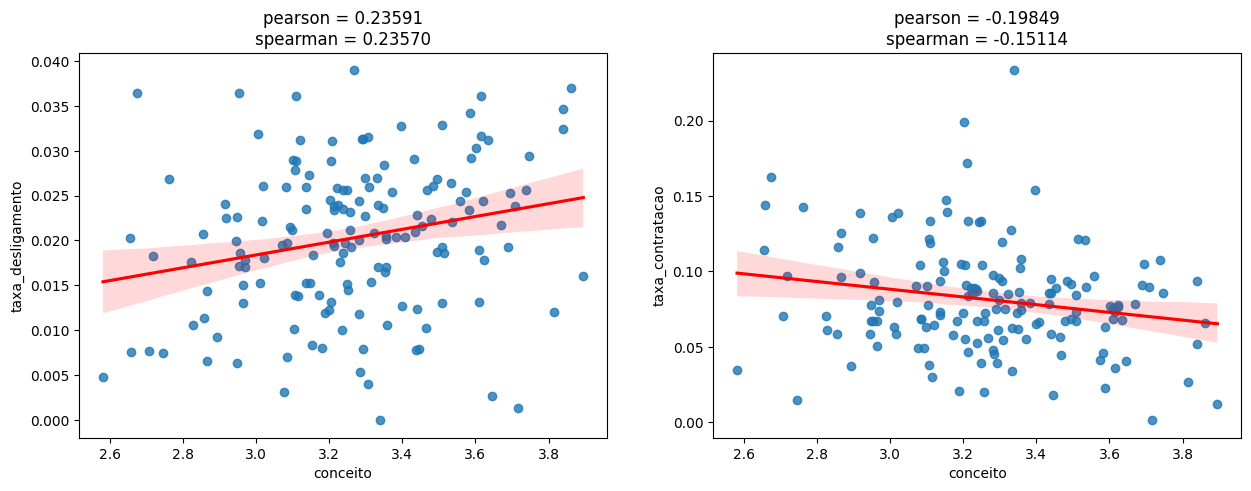

In [217]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Plotando um gráfico para representar a correlação
ax1.set_title(f"pearson = {sig_des_p[0]:.5f}\nspearman = {sig_des_s[0]:.5f}")
sns.regplot(
    y=df_reduzido["taxa_desligamento"], 
    x=df_reduzido["conceito"], 
    line_kws={"color": "red"},
    ax=ax1
)

ax2.set_title(f"pearson = {sig_cont_p[0]:.5f}\nspearman = {sig_cont_s[0]:.5f}")
sns.regplot(
    x=df_reduzido["conceito"],
    y=df_reduzido["taxa_contratacao"],
    line_kws={"color": "red"},
    ax=ax2
)

#### **Discussão**

Pelos resultados, observamos que é possível apontar uma correlação positiva fraca entre a taxa de desligamento e o conceito médio da graduação de uma instituição de ensino federal ao longo dos anos de 2021, 2022 e 2023. 

Analisando a taxa de desligamento, para o teste de Pearson, o coeficiente de correlação foi de *0.2359*, associado a um *p-value* de *0.00293*. No teste de Spearman, o coeficiente foi de *0.2357*, com um *p-value* de *0.00296* (valores aproximados). **Apesar dos coeficientes indicarem uma correlação fraca, o fato de ambos os valores-p serem menores que 0.01 indicam que ela é estatisticamente significativa.**